In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
import fca_interp as fcai

In [3]:
from utils_ import powerset

In [4]:
from importlib import reload

In [5]:
from sklearn.datasets import load_boston

# Attribute Information:

Input variables:

__bank client data:__
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. balance: average yearly balance, in euros (numeric)
7. housing: has housing loan? (categorical: 'no','yes','unknown')
8. loan: has personal loan? (categorical: 'no','yes','unknown')

__related with the last contact of the current campaign:__
9. contact: contact communication type (categorical: 'cellular','telephone')
10. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
11. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
12. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

__other attributes:__
13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

__Output variable (desired target):__
17. y - has the client subscribed a term deposit? (binary: 'yes','no')

In [6]:
real_feats = ['age', 'default', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'balance',]
cat_feats  = ['job', 'marital', 'education', 'contact', 'month', 'poutcome',]

In [7]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')

for f in ['default', 'housing','loan', 'y']:
    bank_ds[f] = bank_ds[f].apply(lambda x: {'no':0, 'yes':1, 'unknown':None}[x])
bank_ds.loc[bank_ds['pdays']==-1, 'pdays'] = None

bank_ds.index = bank_ds.index.astype(str)
bank_ds

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,NaN,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339.0,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330.0,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,NaN,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,NaN,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,0,-333,1,0,cellular,30,jul,329,5,NaN,0,unknown,0
4517,57,self-employed,married,tertiary,1,-3313,1,1,unknown,9,may,153,1,NaN,0,unknown,0
4518,57,technician,married,secondary,0,295,0,0,cellular,19,aug,151,11,NaN,0,unknown,0
4519,28,blue-collar,married,secondary,0,1137,0,0,cellular,6,feb,129,4,211.0,3,other,0


In [8]:
bb = CatBoostClassifier(cat_features=cat_feats)
bb.fit(bank_ds[cat_feats+real_feats], bank_ds['y'], verbose=False, plot=False)
bank_ds['preds'] = bb.predict(bank_ds[cat_feats+real_feats])

In [9]:
bank_ds.to_csv('bank_ds_new.csv')
bank_ds = pd.read_csv('bank_ds_new.csv', index_col=0)

In [10]:
bank_ds.index = bank_ds.index.astype(str)

In [11]:
def get_negative_support(bin_ds, flg, fs=None, drop_negative_duplicates=False):
    fs = fs if fs is not None else bin_ds.columns
    fs = list(fs)
    pos_examples = bin_ds.loc[flg, fs].astype(int)
    neg_examples = bin_ds.loc[~flg, fs].astype(int)
    
    pos_examples = pos_examples.drop_duplicates()            
    if drop_negative_duplicates:
        neg_examples = neg_examples.drop_duplicates()
        coefs = [1]*len(neg_examples)
    else:
        neg_examples = neg_examples.pivot_table(index=fs, aggfunc='size').reset_index()
        coefs = neg_examples[0]
        neg_examples = neg_examples.drop(0, 1)
        
    cross = pos_examples.dot(neg_examples.T)    
    #cross_same = (cross==neg_examples.sum(1))&((cross.T==pos_examples.sum(1)).T)
    cross_same = (cross.T==pos_examples.sum(1)).T # if g_+` 
    neg_support = (cross_same.any(0) * coefs).sum()
    return neg_support

In [12]:
def is_feats_strong(bin_ds, flg, fs=None):
    fs = fs if fs is not None else bin_ds.columns
    neg_support = get_negative_support(bin_ds, flg, fs, drop_negative_duplicates=True)
    return neg_support==0

In [13]:
def calc_cover_of_concepts(concepts):
    return set([str(g) for c in concepts for g in c.get_extent()])

In [14]:
def get_min_concepts(concepts, use_tqdm=True):
    concepts = sorted(concepts, key=lambda c: -len(c.get_extent()))
    for i in tqdm(range(len(concepts)), disable=not use_tqdm):
        if i >= len(concepts):
            break
        
        c = concepts[i]
        lns = set([c_ for c_ in concepts if c_!=c and c_.is_subconcept_of(c)])
        concepts = [c_ for c_ in concepts if c_ not in lns]
    return concepts

In [412]:
def select_smallest_covering_hyps(concepts, use_tqdm=True, use_pruning=False):
    selected_hyps = []
    n_added = []
    n_covered = []
    for i in tqdm(range(len(concepts)), disable=not use_tqdm):
        cncpts_to_check = [c for c in concepts if c not in selected_hyps]
        if len(cncpts_to_check)==0:
            break
        cover = calc_cover_of_concepts(selected_hyps)
        for c in cncpts_to_check:
            c._metrics['n_uncovered'] = len([g for g in c.get_extent() if g not in cover])
        cncpts_to_check = sorted(cncpts_to_check, key=lambda c: (-c._metrics['n_uncovered'], -c._metrics['strongness']))
        n_ = cncpts_to_check[0]._metrics['n_uncovered']
        if n_==0:
            break
        selected_hyps.append(cncpts_to_check[0])
        n_added.append(n_)
        n_covered.append(len(calc_cover_of_concepts(selected_hyps)))
        
    if use_pruning:
        for i in tqdm(range(len(selected_hyps)), desc='pruning', disable=not use_tqdm):
            cover = len(calc_cover_of_concepts(selected_hyps))
            for c in selected_hyps:
                cover_ = len(calc_cover_of_concepts([c_ for c_ in selected_hyps if c_!=c]))
                if cover_==cover:
                    selected_hyps = [c_ for c_ in selected_hyps if c_!=c]
                    break
            else:
                break
    
    return selected_hyps

In [26]:
def construct_bin_ds_from_ints(ints_, bin_ds_old):
    bin_ds = pd.DataFrame()
    for idx, int_ in enumerate(ints_):
        bin_ds[f'int_{idx}'] = bin_ds_old[int_].all(1)
    bin_ds.index = bin_ds_old.index
    return bin_ds

# Анализируем положительные примеры

In [27]:
import fca_interp as fcai

In [28]:
fcai = reload(fcai)

In [29]:
flg = bank_ds['preds']==1
flg.sum()

149

In [113]:
binarizer = fcai.Binarizer()

In [114]:
ths = {}
for f in real_feats:
    ths[f] = sorted(bank_ds.loc[flg, f].unique())
cases = {}

In [115]:
bin_ds, forder = binarizer.binarize_ds(bank_ds[cat_feats+real_feats], cat_feats, ths, cases)
bin_ds.shape, bin_ds[flg].drop_duplicates().T.drop_duplicates().T.shape

((4521, 644), (149, 626))

In [116]:
is_feats_strong(bin_ds, flg)

True

In [126]:
with open('short_feats_pos_samples.txt','r') as f:
    short_feats = f.read().split(',')

In [128]:
len(short_feats), is_feats_strong(bin_ds, flg, short_feats)

(39, True)

In [129]:
bin_pos_ = bin_ds.loc[flg, short_feats].drop_duplicates()
bin_neg_ = bin_ds.loc[~flg, short_feats].drop_duplicates()

for idx, row in tqdm(bin_pos_.iterrows(),total=len(bin_pos_)):
    neg_sup = (bin_neg_==row).all(1).sum()
    assert neg_sup==0, f'Row {idx} is not strong'
else:
    print('Every row is a strong hypothesis')


Every row is a strong hypothesis


In [130]:
from sklearn.metrics import accuracy_score

In [131]:
fcai = reload(fcai)

In [132]:
from datetime import datetime

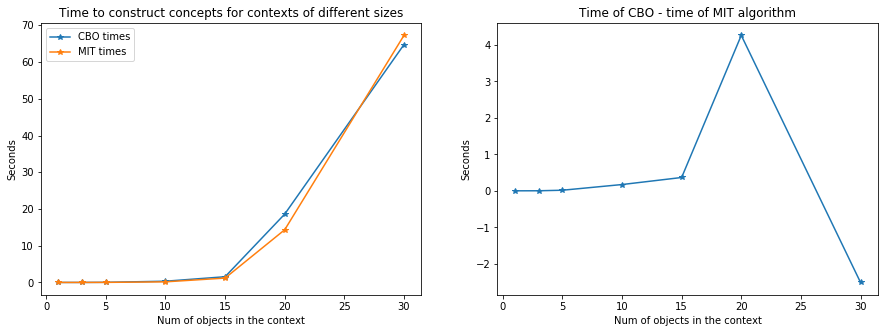

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(sample_sizes, times_cbo, '*-', label='CBO times')
plt.plot(sample_sizes, times_mit, '*-', label='MIT times')
plt.title('Time to construct concepts for contexts of different sizes')
plt.legend()
plt.xlabel('Num of objects in the context')
plt.ylabel('Seconds')

plt.subplot(122)
plt.plot(sample_sizes, np.array(times_cbo)-np.array(times_mit), '*-')
plt.title('Time of CBO - time of MIT algorithm')
plt.xlabel('Num of objects in the context')
plt.ylabel('Seconds')

plt.show()

In [133]:
bin_ds_pos = bin_ds.loc[flg, short_feats]
bin_ds_neg = bin_ds.loc[~flg, short_feats]

In [156]:
cntx_full = fcai.BinaryContext(bin_ds[short_feats], y_true=bank_ds['y'], y_pred=bank_ds['preds'])

In [158]:
cntx = fcai.BinaryContext(bin_ds.loc[flg, short_feats])
cntx

Num of objects: 148, Num of attrs: 39
Objects (len: 148): 36, 49, 70, 83, 98,...
Attrs (len: 39): poutcome__is__success, month__not__jan, age__geq__46, contact__not__unknown, marital__not__married,...

In [252]:
def construct_max_strong_hyps(cntx, cntx_full, use_tqdm=True):
    objs_to_check = sorted(cntx.get_objs(is_full=True))

    concepts = []
    for i in tqdm(range(len(objs_to_check)), disable=not use_tqdm):
        if len(objs_to_check)==0:
            break
        g = objs_to_check.pop(0)

        int_ = cntx.get_intent([g], is_full=True)
        ext_ = cntx.get_extent(int_, is_full=True)    
        ext_full = cntx_full.get_extent(int_, is_full=True)
        strongness = len(ext_)/len(ext_full) if len(ext_)>0 else 0
        assert strongness==1, f'Object {g} is not a strong hypothesis'

        objs_to_check = [g_ for g_ in objs_to_check if g_ not in ext_]
        c = fcai.Concept(ext_, int_, metrics={'strongness':strongness})
        concepts.append(c)
    return concepts

In [253]:
base_concepts = construct_max_strong_hyps(cntx, cntx_full)

In [254]:
len(base_concepts)

144

In [265]:
def _close_by_one_concepts(cntx, cntx_full, strong_concepts, is_monotonic=False, strongness_min_bound=0.5, verb=True):
    n_concepts = len(strong_concepts)

    combs_to_check = [[g_idx] for g_idx in range(len(strong_concepts))]
    concepts = set()
    iter_ = 0
    saved_combs = set()

    t0 = datetime.now()
    while len(combs_to_check) > 0:
        iter_ += 1

        comb = combs_to_check.pop(0)
        
        try:
            ext_united = list(set([g for c_idx in comb for g in strong_concepts[c_idx].get_extent()])) #transforming concepts to their common extents
        except Exception as e:
            if verb:
                print(comb, e)
            raise e
        int_ = cntx.get_intent(ext_united, trust_mode=False, verb=True,)
        ext_ = cntx.get_extent(int_, trust_mode=False, verb=True, is_full=True)
        
        comb_ = [idx for idx, concept in enumerate(strong_concepts) if all([g in ext_ for g in concept.get_extent()])] #transforming extents to their concepts
        
        new_comb_ = [x for x in comb_ if x not in comb]

        t1 = datetime.now()
        dt = (t1 - t0).total_seconds()
        try:
            if verb:
                print(f"{iter_}: len(comb_)={len(comb_)}, first_in_comb: {comb_[0]}, new_comb_len:{len(new_comb_)}, time spend: {dt:.2f} sec, speed: {dt / iter_:.2f} sec/iter")
        except Exception as e:
            if verb:
                print(comb, comb_, e)
            raise e

        if (len(comb) > 0 and any([x < comb[-1] for x in new_comb_])) or tuple(comb_) in saved_combs:
            continue
            
        if strongness_min_bound is not None:
            ext_full = cntx.get_extent(int_, trust_mode=False, verb=True, is_full=True)
            ext_full_ = cntx_full.get_extent(int_, trust_mode=False, verb=True, is_full=True)
            strongness = len(ext_full)/len(ext_full_) if len(ext_full)>0 else 0
            if strongness<strongness_min_bound:
                continue

        concepts.add(fcai.Concept(ext_, int_))
        saved_combs.add(tuple(comb_))

        new_combs = [comb_ + [x] for x in range((comb[-1] if len(comb) > 0 else -1) + 1, n_concepts) if x not in comb_]
        combs_to_check = new_combs + combs_to_check

    return concepts

In [278]:
%%timeit
united_concepts = _close_by_one_concepts(cntx, cntx_full, base_concepts[:10], is_monotonic=False, strongness_min_bound=1, verb=False)

158 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [279]:
%%timeit
united_concepts = _close_by_one_concepts(cntx, cntx_full, base_concepts[:15], is_monotonic=False, strongness_min_bound=1, verb=False)

485 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [280]:
%%timeit
united_concepts = _close_by_one_concepts(cntx, cntx_full, base_concepts[:20], is_monotonic=False, strongness_min_bound=1, verb=False)

796 ms ± 5.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [367]:
fm.calc_strongness()

<bound method FormalManager.calc_strongness of <fca_interp.FormalManager object at 0x7fd0879e3dd0>>

In [651]:
def unite_bootstrap_concepts(cntx, cntx_full, base_concepts, n_epochs=500, sample_size=15, use_tqdm=True, stab_min_bound=None, verb=False,
                                 strongness_min_bound=0.5, n_best_concepts=None, is_monotone=False):
    concepts_bootstrap = []
    for i in tqdm(range(n_epochs), disable=not use_tqdm, desc='boostrap aggregating'):
        np.random.seed(i)
        sample = np.random.choice(base_concepts, size=sample_size, replace=True)
        concepts = _close_by_one_concepts(cntx, cntx_full, sample, is_monotonic=False, strongness_min_bound=strongness_min_bound, verb=False)
        fm = fcai.FormalManager(cntx)
        fm._concepts = concepts
        fm.calc_strongness(cntx_full)
        for idx, c in enumerate(fm.sort_concepts(concepts)):
            c._idx = idx
        fm.construct_lattice()
        fm.calc_stability_approx()
        if stab_min_bound is not None:
            fm.filter_concepts(lambda c: fcai.get_not_none(c._metrics['stab_min_bound'],-100)>=stab_min_bound)
        
        concepts = list(fm.get_concepts())
        if n_best_concepts is not None:
            #concepts = sorted(concepts, key=lambda c: (-c._metrics.get('stab_min_bound',0), -c._metrics.get('strongness',0)))[:n_best_concepts]
            concepts = sorted(concepts, key=lambda c: (-fcai.get_not_none(c._metrics['stab_min_bound'],-100), -fcai.get_not_none(c._metrics['strongness'],-100)))[:n_best_concepts]
        
        concepts_bootstrap += concepts
    return concepts_bootstrap

In [519]:
int_ = cntx.get_intent([], is_full=True)
ext_ = cntx.get_extent(int_, is_full=True)
ext_full = cntx.get_extent(int_, is_full=True)
bottom_concept = fcai.Concept(ext_, int_, metrics={'strongness':len(ext_)/len(ext_full) if len(ext_)>0 else 0})

ext_ = cntx.get_extent([], is_full=True)
int_ = cntx.get_intent(ext_, is_full=True)
ext_full = cntx.get_extent(int_, is_full=True)
top_concept = fcai.Concept(ext_, int_, metrics={'strongness':len(ext_)/len(ext_full) if len(ext_)>0 else 0})

In [596]:
best_concepts_by_iters = {}

In [644]:
np.arange(0,1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [652]:
def get_unique_concepts(concepts):
    saw_ints = set()
    unique_concepts = []
    for c in concepts:
        int_ = tuple(c.get_intent())
        if int_ not in saw_ints:
            unique_concepts.append(c)
            saw_ints.add(int_)
    return unique_concepts

In [661]:
def agglomerative_concepts_construction(cntx, cntx_full, base_concepts, strongness_delta=0.1, stab_min_bound=0.5,
                                        use_tqdm=True, n_epochs_bootstrap=100, n_best_concepts_bootstrap=10, verb=True):
    int_ = cntx.get_intent([], is_full=True)
    ext_ = cntx.get_extent(int_, is_full=True)
    ext_full = cntx.get_extent(int_, is_full=True)
    bottom_concept = fcai.Concept(ext_, int_, metrics={'strongness':len(ext_)/len(ext_full) if len(ext_)>0 else 0})
        
    strong_bounds = np.arange(0,1+strongness_delta,strongness_delta)[::-1]
    min_concepts_by_iters = {}
    selected_concepts = []
    
    mc = base_concepts.copy()
    for iter_idx, strong_bound in tqdm(enumerate(strong_bounds), disable=not use_tqdm, total=len(strong_bounds), desc='agglomerative construction'):
        bs_concepts = unite_bootstrap_concepts(cntx, cntx_full, mc,
                                               n_epochs=n_epochs_bootstrap, n_best_concepts=n_best_concepts_bootstrap, strongness_min_bound=strong_bound)
        unique_concepts = get_unique_concepts(bs_concepts)
        if verb:
            print(f'Iter {iter_idx}: num bs unique concepts: {len(unique_concepts)}')
        
        concepts = unique_concepts+selected_concepts+[bottom_concept]+(base_concepts if iter_idx==0 else [])
        if verb:
            print(f'Iter {iter_idx}: num concept to fm: {len(concepts)}')
            
        fm = fcai.FormalManager(cntx)
        fm._concepts = concepts
        for idx, c in enumerate(fm.sort_concepts(concepts)):
            c._idx = idx
        fm.construct_lattice()
        fm.calc_stability_approx()
        concepts = fm.get_concepts()
        
        if verb:
            print(f'Iter {iter_idx}: cover of all concepts: {len(calc_cover_of_concepts(concepts))}')
        stab_concepts = [c for c in concepts if fcai.get_not_none(c._metrics['stab_min_bound'],-100)>=stab_min_bound]
        
        if verb:
            print(f'Iter {iter_idx}: cover of stable concepts: {len(calc_cover_of_concepts(stab_concepts))}')
        
        mc = select_smallest_covering_hyps(stab_concepts, use_pruning=True)
        if verb:
            print(f'Iter {iter_idx}: cover of min stable concepts: {len(calc_cover_of_concepts(mc))}')
            print(f'Iter {iter_idx}: num of min stable concepts: {len(mc)}')
        selected_concepts = get_unique_concepts(selected_concepts+mc)
        if verb:
            print(f'Iter {iter_idx}: num of selected concepts: {len(selected_concepts)}')
        min_concepts_by_iters[iter_idx] = mc
    return selected_concepts, min_concepts_by_iters

In [662]:
selected_concepts, min_concepts_by_iters = agglomerative_concepts_construction(cntx, cntx_full, base_concepts, )


Iter 0: num bs unique concepts: 847
Iter 0: num concept to fm: 992
Iter 0: cover of all concepts: 149
Iter 0: cover of stable concepts: 149


Iter 0: cover of min stable concepts: 149
Iter 0: num of min stable concepts: 50
Iter 0: num of selected concepts: 50





Iter 1: num bs unique concepts: 129
Iter 1: num concept to fm: 180
Iter 1: cover of all concepts: 149
Iter 1: cover of stable concepts: 149


Iter 1: cover of min stable concepts: 149
Iter 1: num of min stable concepts: 39
Iter 1: num of selected concepts: 56





Iter 2: num bs unique concepts: 61
Iter 2: num concept to fm: 118
Iter 2: cover of all concepts: 149
Iter 2: cover of stable concepts: 149


Iter 2: cover of min stable concepts: 149
Iter 2: num of min stable concepts: 32
Iter 2: num of selected concepts: 60





Iter 3: num bs unique concepts: 40
Iter 3: num concept to fm: 101
Iter 3: cover of all concepts: 149
Iter 3: cover of stable concepts: 149


Iter 3: cover of min stable concepts: 149
Iter 3: num of min stable concepts: 28
Iter 3: num of selected concepts: 62





Iter 4: num bs unique concepts: 44
Iter 4: num concept to fm: 107
Iter 4: cover of all concepts: 149
Iter 4: cover of stable concepts: 149


Iter 4: cover of min stable concepts: 149
Iter 4: num of min stable concepts: 22
Iter 4: num of selected concepts: 68





Iter 5: num bs unique concepts: 35
Iter 5: num concept to fm: 104
Iter 5: cover of all concepts: 149
Iter 5: cover of stable concepts: 149


Iter 5: cover of min stable concepts: 149
Iter 5: num of min stable concepts: 19
Iter 5: num of selected concepts: 71





Iter 6: num bs unique concepts: 30
Iter 6: num concept to fm: 102
Iter 6: cover of all concepts: 149
Iter 6: cover of stable concepts: 149


Iter 6: cover of min stable concepts: 149
Iter 6: num of min stable concepts: 15
Iter 6: num of selected concepts: 75





Iter 7: num bs unique concepts: 18
Iter 7: num concept to fm: 94
Iter 7: cover of all concepts: 149
Iter 7: cover of stable concepts: 149


Iter 7: cover of min stable concepts: 149
Iter 7: num of min stable concepts: 14
Iter 7: num of selected concepts: 76





Iter 8: num bs unique concepts: 26
Iter 8: num concept to fm: 103
Iter 8: cover of all concepts: 149
Iter 8: cover of stable concepts: 149


Iter 8: cover of min stable concepts: 149
Iter 8: num of min stable concepts: 9
Iter 8: num of selected concepts: 80





Iter 9: num bs unique concepts: 18
Iter 9: num concept to fm: 99
Iter 9: cover of all concepts: 149
Iter 9: cover of stable concepts: 149


/opt/lib/fca_interp.py:589: RuntimeWarning:

divide by zero encountered in log2

/opt/lib/fca_interp.py:590: RuntimeWarning:

divide by zero encountered in log2



Iter 9: cover of min stable concepts: 149
Iter 9: num of min stable concepts: 5
Iter 9: num of selected concepts: 83



Iter 10: num bs unique concepts: 19
Iter 10: num concept to fm: 103
Iter 10: cover of all concepts: 149
Iter 10: cover of stable concepts: 149


Iter 10: cover of min stable concepts: 149
Iter 10: num of min stable concepts: 2
Iter 10: num of selected concepts: 84



In [718]:
selected_concepts = get_unique_concepts([c for vs in min_concepts_by_iters.values() for c in vs])

In [719]:
selected_concepts = sorted(selected_concepts, key=lambda c: len(c.get_extent()))
for i in tqdm(range(len(selected_concepts))):
    if i>= len(selected_concepts):
        break
    c = selected_concepts[i]
    if c._metrics['strongness']<1:
        continue
    low_neighbs = [c_ for c_ in selected_concepts if c_.is_subconcept_of(c) and c!=c_]
    selected_concepts = [c_ for c_ in selected_concepts if c_ not in low_neighbs]

In [720]:
len(selected_concepts)

82

In [933]:
fm = fcai.FormalManager(cntx)
fm._concepts = [fcai.Concept(c.get_extent(), c.get_intent(), metrics=c._metrics) for c in selected_concepts+[top_concept]+[bottom_concept]]
for idx, c in enumerate(fm.sort_concepts(fm.get_concepts())):
    c._idx = idx
fm.calc_strongness(cntx_full)
fm.construct_lattice()
fm.calc_stability_approx()
concepts = fm.get_concepts()

In [942]:
fig = fm.get_plotly_fig(color_by='stab_min_bound', sort_by='strongness', level_sort=3, new_attrs_lim=1, new_objs_lim=1)

/root/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [943]:
fig.show()

In [941]:
stab_concepts = [c for c in fm.get_concepts() if fcai.get_not_none(c._metrics['stab_min_bound'],-100)>=0.9]
len(calc_cover_of_concepts(stab_concepts)), len(stab_concepts), len(calc_cover_of_concepts([c for c in stab_concepts if c._metrics['strongness']>=0.5]))/flg.sum()

(149, 60, 0.9395973154362416)

In [938]:
fm_stab = fcai.FormalManager(cntx)
fm_stab._concepts = [fcai.Concept(c.get_extent(), c.get_intent(), metrics=c._metrics.copy()) for c in stab_concepts+[top_concept]]#+[bottom_concept]
for idx, c in enumerate(fm_stab.sort_concepts(fm_stab.get_concepts())):
    c._idx = idx
fm_stab.calc_strongness(cntx_full)
fm_stab.construct_lattice()
fm_stab.calc_stability_approx()
#concepts = fm.get_concepts()

In [939]:
fig_stab = fm_stab.get_plotly_fig(color_by='strongness', sort_by='strongness', level_sort=3, new_attrs_lim=1, new_objs_lim=1)

In [940]:
fig_stab.show()

# Calc feature importances

In [976]:
fimps = {}

In [983]:
fm.get_concept_by_id(0)._up_neighbs

set()

In [1071]:
fimps = {}
for c in fm.get_concepts():
    if len(c.get_extent())==0:
        continue
    for un_idx in c._up_neighbs:
        un = fm.get_concept_by_id(un_idx)
        new_int = set(c.get_intent())-set(un.get_intent())
        new_feats = set([m.split('__')[0] for m in new_int])
        strongness_diff = c._metrics['strongness'] - un._metrics['strongness']
        for f in new_feats:
            fimps[f] = fimps.get(f,[])+[strongness_diff/len(new_feats)]
fimps

{'age': [0.07936507936507937,
  0.09537065999374414,
  0.125,
  0.09,
  0.05499999999999999,
  0.1,
  0.08503225806451613,
  0.023148148148148154,
  0.10000000000000002,
  0.1673469387755102,
  0.19166666666666665,
  0.125,
  0.08602150537634408,
  0.06000000000000001,
  0.09448028673835125,
  0.05627705627705627,
  0.10629032258064516,
  0.08503225806451613,
  0.02799650043744532,
  0.027777777777777773,
  0.09537065999374414,
  0.13945578231292519,
  0.075,
  0.08518518518518518,
  0.11111111111111112,
  0.022196261682242993,
  0.10981749528005035,
  0.14516129032258066,
  0.0967741935483871,
  0.17037037037037037,
  0.075,
  0.06666666666666668,
  0.12096774193548387,
  0.22499999999999998,
  0.08503225806451613,
  0.02799650043744532,
  0.1074074074074074,
  0.07843137254901962,
  0.09090909090909088,
  0.11224489795918369,
  0.011764705882352944,
  0.10981749528005035,
  0.10658153241650295,
  0.0357142857142857,
  0.08014354066985646,
  0.017241379310344817,
  0.09609030837004405

In [1073]:
for f in cat_feats+real_feats:
    if f not in fimps:
        fimps[f] = [0]

In [1080]:
fimps_mean = pd.Series({k:np.mean(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)
fimps_median = pd.Series({k:np.median(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)
fimps_sum = pd.Series({k:np.sum(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)

fimps_mean /= fimps_mean.sum()
fimps_median /= fimps_median.sum()
fimps_sum /= fimps_sum.sum()

In [1009]:
pool = Pool(bank_ds.loc[flg, cat_feats+real_feats], cat_features=cat_feats)

In [1022]:
sv = pd.DataFrame(bb.get_feature_importance(pool, type='ShapValues'), columns=cat_feats+real_feats+['bias']).drop('bias',1)
sv = sv.abs().mean()
sv /= sv.sum()
sv = sv.sort_values(ascending=False)

In [1023]:
sv

poutcome     0.365855
month        0.151731
contact      0.088716
pdays        0.073109
age          0.064318
balance      0.059707
housing      0.039846
marital      0.037364
previous     0.036784
education    0.030353
job          0.024951
loan         0.015515
campaign     0.010593
default      0.001158
dtype: float64

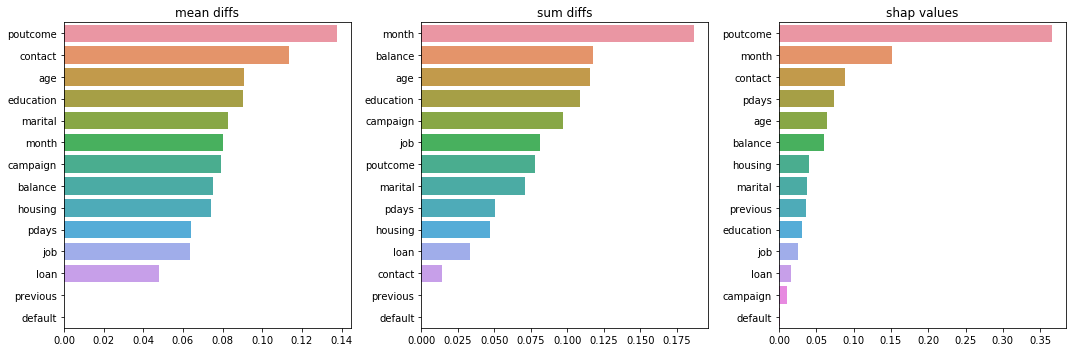

In [1081]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.barplot(y=fimps_mean.index, x=fimps_mean.values)
plt.title('mean diffs')

plt.subplot(132)
sns.barplot(y=fimps_sum.index, x=fimps_sum.values)
plt.title('sum diffs')

plt.subplot(133)
sns.barplot(y=sv.index, x=sv.values)
plt.title('shap values')

plt.tight_layout()
plt.show()

# Интерпретируем минимальные понятия

In [1194]:
sc = select_smallest_covering_hyps([c for c in fm_stab.get_concepts() if c._metrics['strongness']>=0.7], use_pruning=True)
len(sc), len(calc_cover_of_concepts(sc)), len(calc_cover_of_concepts(sc))/flg.sum()

(16, 138, 0.9261744966442953)

In [1195]:
[len(c.get_extent()) for c in sc]

[95, 18, 13, 4, 7, 5, 5, 4, 7, 8, 4, 4, 4, 5, 5, 5]

In [1200]:
len(calc_cover_of_concepts(sc[:7]))/flg.sum()

0.8456375838926175

In [1214]:
def get_short_intent(int_, cntx_full, use_tqdm=True):
    int_short = int_.copy()
    for i in tqdm(range(len(int_short)), disable=not use_tqdm):
        for m in int_short:
            if len(cntx_full.get_extent([m_ for m_ in int_short if m_!=m]))==len(cntx_full.get_extent(int_short)):
                #print(m)
                int_short = [m_ for m_ in int_short if m_!=m]
                break
        else:
            break
    return int_short

## Понятие 1

In [1264]:
int_ = sc[0].get_intent()
int_short = get_short_intent(int_, cntx_full, use_tqdm=False)

int_ = sorted(int_, key=lambda x: x.split('__')[0])
int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [1265]:
int_

['contact__not__unknown', 'poutcome__is__success', 'poutcome__not__failure']

In [1266]:
int_short

['contact__not__unknown', 'poutcome__is__success']

Клиенты с хорошей историей

## Понятие 2

In [1267]:
int_ = sc[1].get_intent()
int_short = get_short_intent(int_, cntx_full, use_tqdm=False)

int_ = sorted(int_, key=lambda x: x.split('__')[0])
int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [1268]:
int_

['balance__geq__100',
 'balance__leq__3940',
 'balance__geq__229',
 'campaign__leq__4',
 'contact__not__unknown',
 'job__not__admin.',
 'loan__leq__0',
 'month__not__jan',
 'month__not__nov',
 'month__not__may',
 'month__not__apr',
 'month__not__feb',
 'month__not__jun',
 'month__not__sep',
 'month__not__mar',
 'month__not__oct',
 'pdays__geq__38.0',
 'pdays__geq__181.0']

In [1269]:
int_short

['balance__leq__3940',
 'balance__geq__229',
 'campaign__leq__4',
 'job__not__admin.',
 'loan__leq__0',
 'month__not__jan',
 'month__not__nov',
 'month__not__may',
 'month__not__apr',
 'month__not__feb',
 'month__not__jun',
 'month__not__sep',
 'month__not__mar',
 'month__not__oct',
 'pdays__geq__181.0']

## Понятие 3

In [1270]:
int_ = sc[2].get_intent()
int_short = get_short_intent(int_, cntx_full, use_tqdm=False)

int_ = sorted(int_, key=lambda x: x.split('__')[0])
int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [1271]:
int_

['balance__leq__3940',
 'contact__not__unknown',
 'job__not__blue-collar',
 'job__not__admin.',
 'loan__leq__0',
 'marital__not__married',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__sep',
 'month__not__mar',
 'pdays__geq__38.0',
 'pdays__leq__185.0']

In [1272]:
int_short

['balance__leq__3940',
 'job__not__blue-collar',
 'job__not__admin.',
 'loan__leq__0',
 'marital__not__married',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__sep',
 'month__not__mar',
 'pdays__leq__185.0']

## Понятие 4

In [1273]:
int_ = sc[3].get_intent()
int_short = get_short_intent(int_, cntx_full, use_tqdm=False)

int_ = sorted(int_, key=lambda x: x.split('__')[0])
int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [1274]:
int_

['age__geq__41',
 'age__leq__56',
 'balance__leq__302',
 'balance__leq__3940',
 'balance__leq__262',
 'campaign__leq__4',
 'contact__not__unknown',
 'education__not__tertiary',
 'job__not__blue-collar',
 'marital__not__married',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__jun',
 'month__not__sep',
 'poutcome__not__failure']

In [1275]:
int_short

['age__geq__41',
 'age__leq__56',
 'balance__leq__262',
 'education__not__tertiary',
 'marital__not__married',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__jun']

## Понятие 5

In [1277]:
int_ = sc[4].get_intent()
int_short = get_short_intent(int_, cntx_full, use_tqdm=False)

int_ = sorted(int_, key=lambda x: x.split('__')[0])
int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [1278]:
int_

['balance__leq__302',
 'balance__leq__3940',
 'balance__leq__262',
 'campaign__leq__4',
 'contact__not__unknown',
 'education__not__secondary',
 'job__not__blue-collar',
 'job__not__admin.',
 'loan__leq__0',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__jun',
 'month__not__sep',
 'month__not__mar',
 'poutcome__not__failure']

In [1279]:
int_short

['balance__leq__262',
 'education__not__secondary',
 'job__not__blue-collar',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__jun',
 'month__not__sep',
 'month__not__mar',
 'poutcome__not__failure']

## Понятие 6

In [1280]:
int_ = sc[5].get_intent()
int_short = get_short_intent(int_, cntx_full, use_tqdm=False)

int_ = sorted(int_, key=lambda x: x.split('__')[0])
int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [1281]:
int_

['age__geq__46',
 'age__geq__41',
 'balance__leq__3940',
 'campaign__leq__4',
 'contact__not__unknown',
 'education__not__tertiary',
 'housing__leq__0',
 'job__not__blue-collar',
 'job__not__admin.',
 'loan__leq__0',
 'marital__not__married',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__sep',
 'month__not__oct',
 'poutcome__not__failure']

In [1282]:
int_short

['age__geq__46',
 'campaign__leq__4',
 'contact__not__unknown',
 'education__not__tertiary',
 'job__not__admin.',
 'loan__leq__0',
 'marital__not__married',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__feb',
 'month__not__oct',
 'poutcome__not__failure']

## Понятие 7

In [1283]:
int_ = sc[7].get_intent()
int_short = get_short_intent(int_, cntx_full, use_tqdm=False)

int_ = sorted(int_, key=lambda x: x.split('__')[0])
int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [1284]:
int_

['age__leq__56',
 'balance__leq__302',
 'balance__leq__3940',
 'balance__leq__262',
 'campaign__leq__4',
 'campaign__geq__2',
 'contact__not__unknown',
 'education__not__tertiary',
 'job__not__admin.',
 'loan__leq__0',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__sep',
 'month__not__oct',
 'poutcome__not__failure']

In [1285]:
int_short

['age__leq__56',
 'balance__leq__262',
 'campaign__geq__2',
 'contact__not__unknown',
 'education__not__tertiary',
 'job__not__admin.',
 'month__not__jan',
 'month__not__nov',
 'month__not__aug',
 'month__not__may',
 'month__not__jul',
 'month__not__apr',
 'month__not__feb',
 'month__not__sep',
 'month__not__oct']

# Attribute Information:

Input variables:

__bank client data:__
1. - age (numeric)
2. - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
3. - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. - education (categorical: "unknown","secondary","primary","tertiary")
5. - default: has credit in default? (binary: "yes","no")
6. - balance: average yearly balance, in euros (numeric) 
7. - housing: has housing loan? (binary: "yes","no")
8. - loan: has personal loan? (binary: "yes","no")

__related with the last contact of the current campaign:__
9. - contact: contact communication type (categorical: "unknown","telephone","cellular") 
10. - day: last contact day of the month (numeric)
11. - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. - duration: last contact duration, in seconds (numeric)

__other attributes:__
13. - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. - previous: number of contacts performed before this campaign and for this client (numeric)
16. - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
17. - y - has the client subscribed a term deposit? (binary: "yes","no")